### Frequency extraction

In [19]:
%matplotlib inline
import soundfile as sf
import IPython.display as ipd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import scipy
from librosa.display import specshow

In [8]:
VIBRATO_WAV = '../datasets/guitar/vibrato.wav'

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

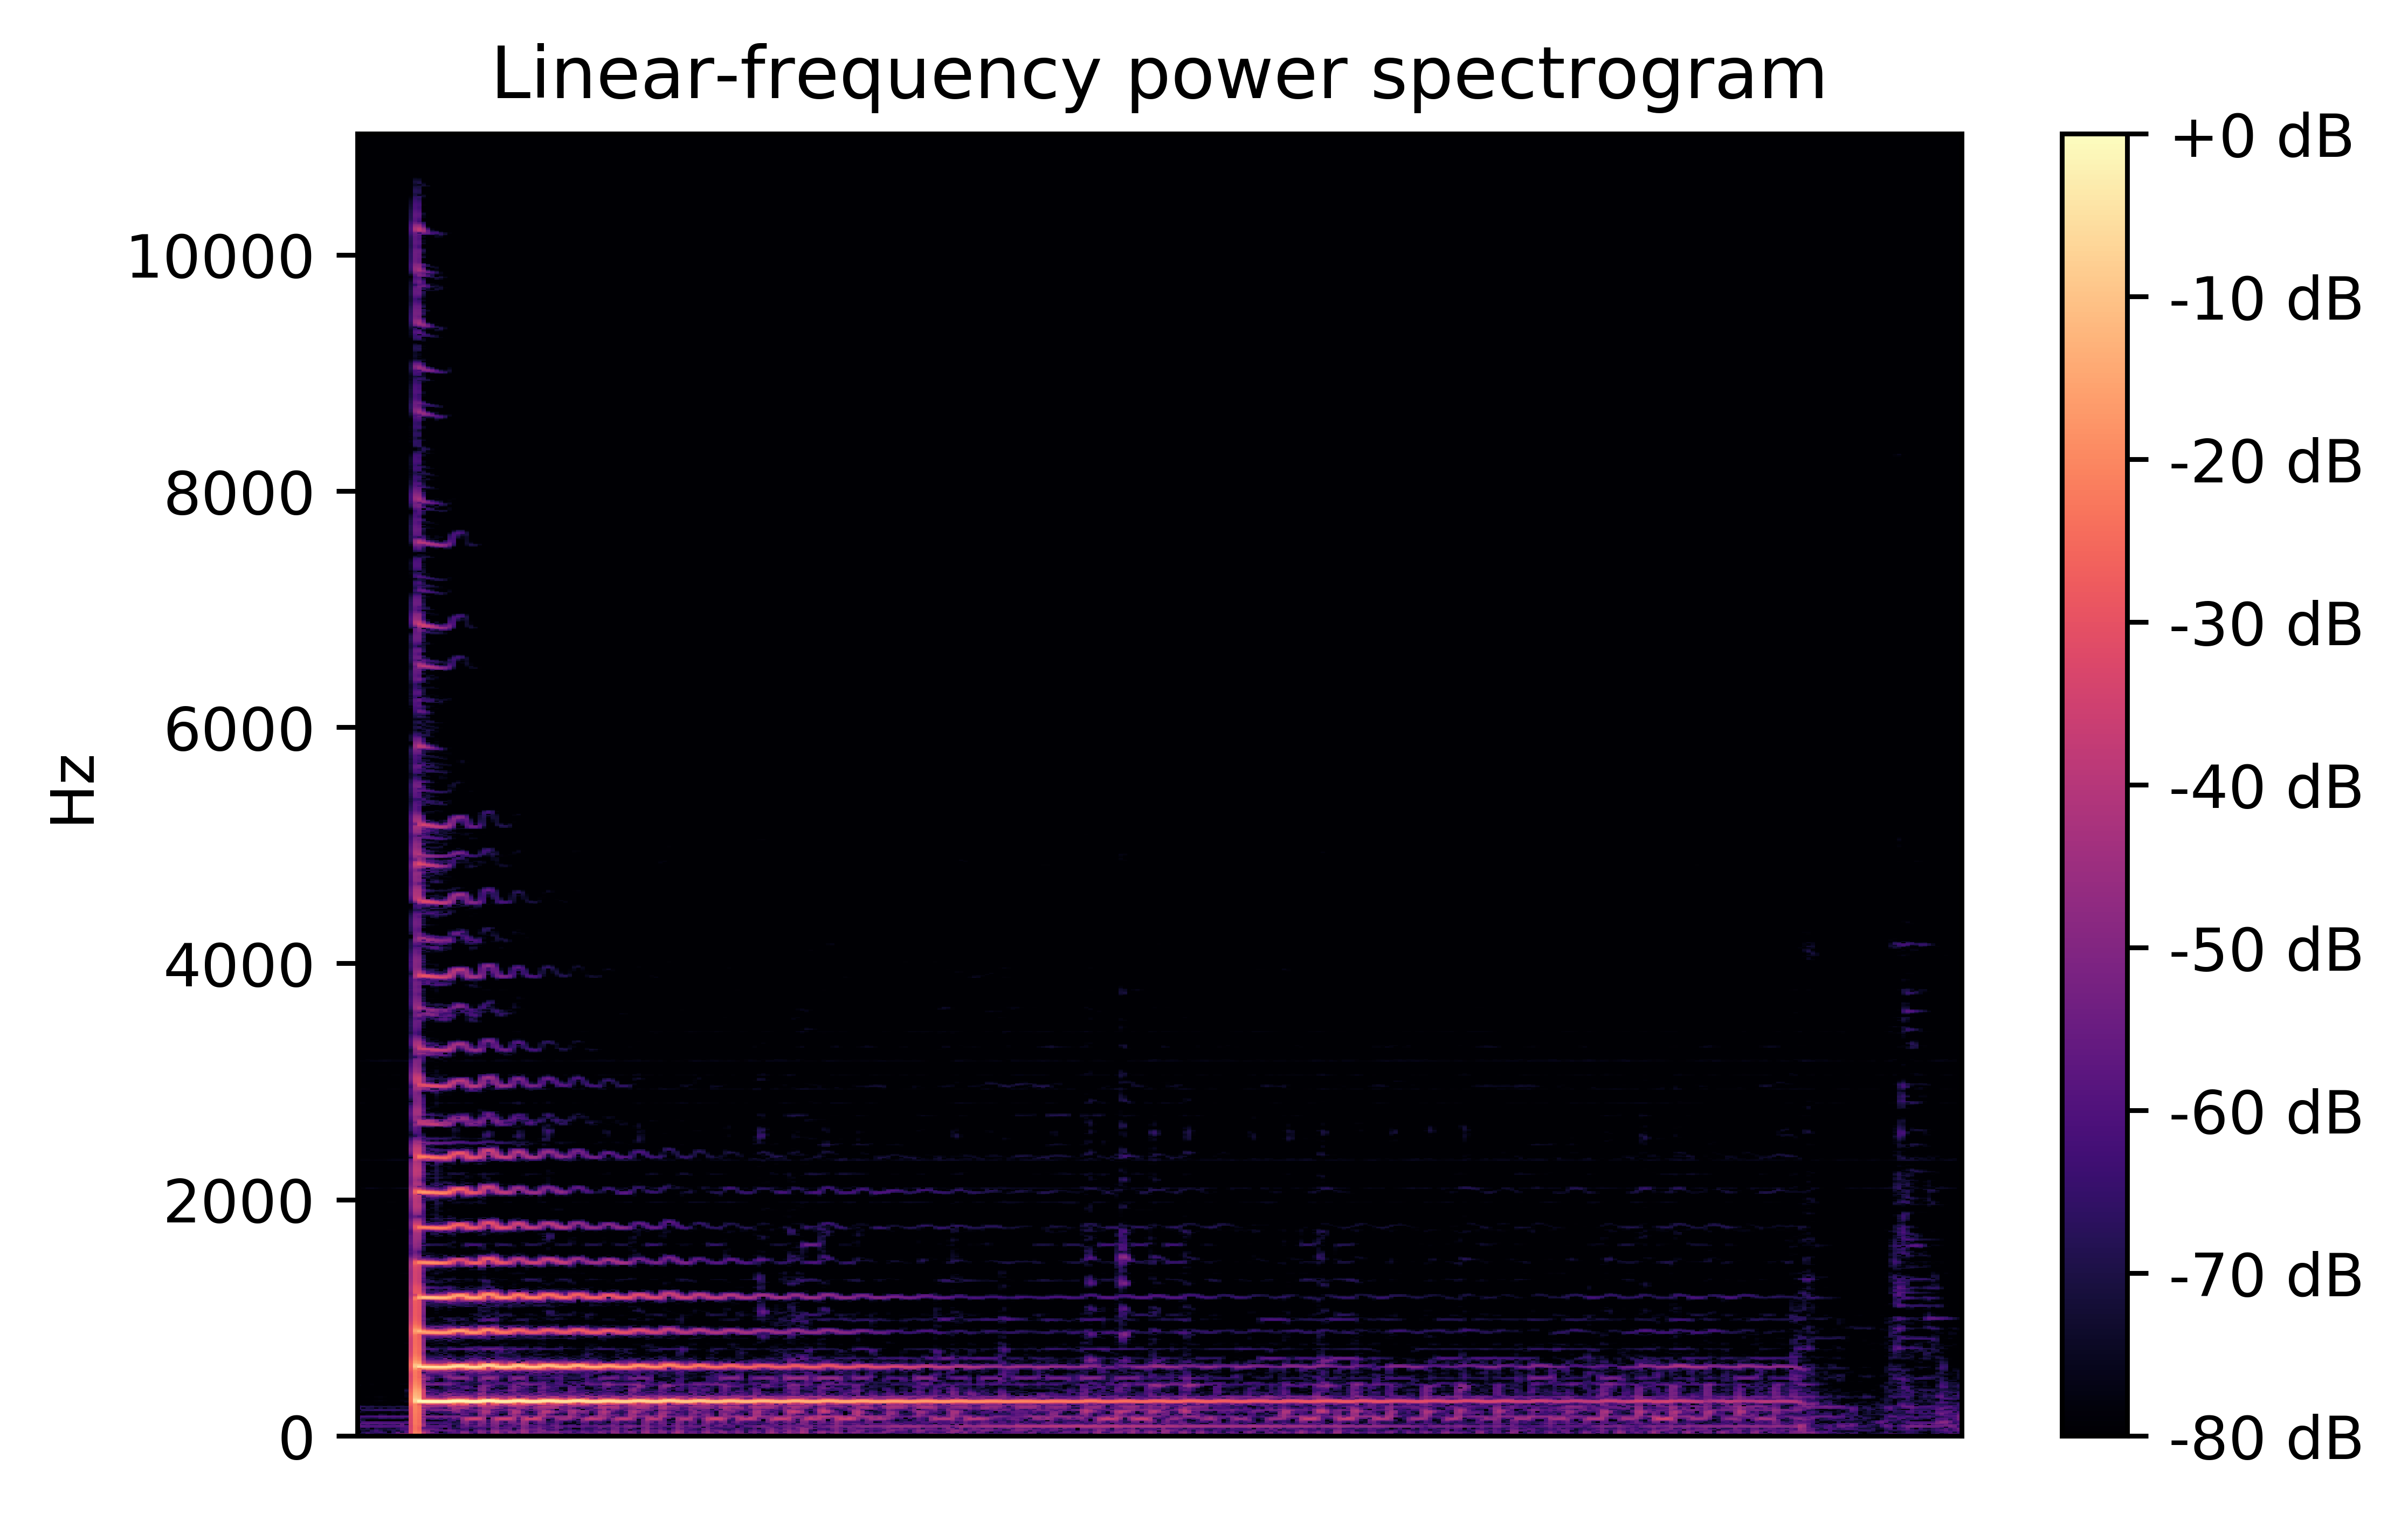

In [33]:
import matplotlib.pyplot as plt
y, sr = librosa.load(VIBRATO_WAV)
plt.figure(dpi=800)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# plt.subplot(4, 2, 1)
specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

create an algorithm that extracts the N loudest frequencies and returns them